In [2]:
import numpy as np
import pandas as pd
import random
import math
import statistics as stat
import matplotlib.pyplot as plt
import itertools
import warnings

In [3]:
def mmn_queueing_jsq(n,arrival_rate,service_rate,simulation_time=60,simuseed=math.nan,policy="jsq1"):
    '''
    Simulating the mmn queueing system using the method of JSQ 
    (namely join the shortest queue method), the user needs to provide
    the number of servers (n),arrival rate (lambda) and service rate (mu),
    in case of n >= 2, if mu is provided as a scaler, then all servers
    share the same mu, if mu is provided as a vector, then all servers may have different mu,
    the simulation time is by default 60 units, and for reproducibility purposes, the user
    can define simulation seed, by default the seed value is not set.
    
    There are 6 inputs in this function,
    n:                the number of servers, a positive finite integer
    arrival_rate:     exponential rate of arrival
    service_rate:     exponential rate of service time
    simulation_time:  the simulation time, a positive finite number
    simuseed:         the simulation seed number
    policy:           there are different policies you may choose to implement the jsq system
    {
    jsq1: Join the shortest queue, if tied, choose randomly from the shortest queue (default)
    jsq2: Join the shortest queue, if tied, choose larger mu, if still tied,
          choose randomly from the shortest queue
    jiq1: Join the idle queue randomly, if no idle queue, choose a queue randomly
    jiq2: Join the idle queue with largest mu, if tied, choose randomly,
          if no idle queue, choose a queue randomly
    jiq3: Join the idle queue randomly, if no idle queue, choose a queue with largest mu,
          if tied, choose randomly
    jiq4: Join the idle queue with largest mu, if tied, choose randomly, if no idle queue,
          choose a queue with largest mu, if tied, choose randomly
    jswq: Join the smallest workload queue, based on the expected waiting time, if tied, choose randomly
    }
    
    There are 8 outputs in this function,
    event_calendar:   the event calendar for the whole simulation, containing all important
                      information needed (current time, next customer arrival time, finish time,
                      server occupancy variable, server next available time, server queue length,
                      server total, grand queue length and grand total)
    utiliz:           the utilization for each server
    ans:              the average number in the system for each server and grand average
    aql:              the average queue length for each server and grand average
    awt:              the average waiting time for each customer and grand average
    act:              the average cycle time for each customer and grand average
    no_cust_arr_comp: the table illustrating the number of arrived customers and the
                      the number of completed services for each server and grand total
    other_stat:       return other calculated statistics, for plotting purposes
    
    Code writer: Yaozu Li
    uoe S.No: 2298215
    
    '''

    if math.isnan(simuseed) == True:
        pass
    else:
        random.seed(simuseed)
        np.random.seed(simuseed)

    if not type(n) is int:
        raise TypeError("n needs to be integer")
    if n < 0:
        raise Exception("n needs to be positive")
    
    lamb =  arrival_rate
    
    if isinstance(service_rate, list):
        if len(service_rate) == n:
            mu = service_rate
        elif (n > 1 and len(service_rate) == 1):
            mu = n*service_rate
        else:
            raise Exception("Unmatched cardinality for service rate and n")
    elif isinstance(service_rate, int) or isinstance(service_rate, float):
        if n == 1:
            mu = [service_rate]
        elif n > 1:
            mu = n*[service_rate]
    else:
        raise Exception("Please use int, float or list type for service rate")
    
    mu = np.array(mu)

    def jsq_policy(plc):
        if plc == "jsq1":
            #Join the shortest queue, if tied, choose randomly from the shortest queue (default)
            sa = random.choice(np.where(event_calendar[-1,total_col] == \
                                   min(event_calendar[-1,total_col]))[0])
        elif plc == "jsq2":
            #Join the shortest queue, if tied, choose larger mu, if still tied,
            #choose randomly from the shortest queue
            shortest_queues = np.where(event_calendar[-1,total_col] == \
                                   min(event_calendar[-1,total_col]))[0]
            if len(shortest_queues) == 1:
                sa = shortest_queues[0]
            elif len(shortest_queues) > 1:
                sa = shortest_queues[random.choice(np.where(mu[shortest_queues] == max(mu[shortest_queues]))[0])]
            
        elif plc == "jiq1":
            #Join the idle queue randomly, if no idle queue, choose a queue randomly
            idle_queues = np.where(event_calendar[-1,total_col] == 0)[0]
            if len(idle_queues) > 0:
                sa = random.choice(idle_queues)
            elif len(idle_queues) == 0:
                sa = random.choice(np.arange(n))
            
        elif plc == "jiq2":
            #Join the idle queue with largest mu, if tied, choose randomly,
            #if no idle queue, choose a queue randomly
            idle_queues = np.where(event_calendar[-1,total_col] == 0)[0]
            if len(idle_queues) > 0:
                sa = idle_queues[random.choice(np.where(mu[idle_queues] == max(mu[idle_queues]))[0])]
            elif len(idle_queues) == 0:
                sa = random.choice(np.arange(n))
            
        elif plc == "jiq3":
            #Join the idle queue randomly, if no idle queue, choose a queue with largest mu,
            #if tied, choose randomly
            idle_queues = np.where(event_calendar[-1,total_col] == 0)[0]
            if len(idle_queues) > 0:
                sa = random.choice(idle_queues)
            elif len(idle_queues) == 0:
                sa = random.choice(np.where(mu == max(mu))[0])
            
        elif plc == "jiq4":
            #Join the idle queue with largest mu, if tied, choose randomly, if no idle queue,
            #choose a queue with largest mu, if tied, choose randomly
            idle_queues = np.where(event_calendar[-1,total_col] == 0)[0]
            if len(idle_queues) > 0:
                sa = idle_queues[random.choice(np.where(mu[idle_queues] == max(mu[idle_queues]))[0])]
            elif len(idle_queues) == 0:
                sa = random.choice(np.where(mu == max(mu))[0])
            
        elif plc == "jswq":
            #Join the smallest workload queue, based on the expected waiting time,
            #if tied, choose randomly
            exp_time = (1/mu)*event_calendar[-1,total_col]
            sa = random.choice(np.where(exp_time == min(exp_time))[0])
        
        return sa
    
    # Record the start/queue/finish timing for each arrival
    for i in range(1,n+1):
        exec(f'serverlog_{i} = []')
    timing_table = np.zeros(5)
    
    # Simulating the event calendar
    table_col = np.arange(n)*4+3
    avail_col = np.arange(n)*4+4
    queue_col = np.arange(n)*4+5
    total_col = np.arange(n)*4+6
    compare_col = np.insert(avail_col,0,[1,2])
    
    event_calendar = np.zeros([2,4+4*n])
    event_calendar[-1,1] = random.expovariate(lamb)
    event_calendar[-1,2] = simulation_time
    event_calendar[-1,avail_col] = math.nan
    
    no_customers = np.zeros(n+1)  # keep track of the number customers
    no_completed_service = np.zeros(n+1)   # keep track of the number of completed services
    arrival_label = 0    # keep track on each arrival's label
    
    while event_calendar[-1,0] < simulation_time:
        event_calendar = np.vstack([event_calendar,event_calendar[-1,:]])
        event_calendar[-1,0] = min(event_calendar[-2,compare_col])
        
        # If the next event is an arrival
        if event_calendar[-1,0] == event_calendar[-2,1]:
            event_calendar[-1,1] = event_calendar[-1,0]+random.expovariate(lamb)
            server_assignment = jsq_policy(policy)
            no_customers[server_assignment] += 1
            arrival_label += 1
            
            eval(f'serverlog_{server_assignment+1}').append(arrival_label)
            timing_table = np.vstack([timing_table,np.zeros(5)])
            timing_table[-1,0] = arrival_label
            timing_table[-1,1] = event_calendar[-1,0]
            timing_table[-1,4] = server_assignment+1
            
            # If the server is not occupied
            if event_calendar[-1,table_col[server_assignment]] == 0:
                event_calendar[-1,table_col[server_assignment]] += 1
                event_calendar[-1,avail_col[server_assignment]] = event_calendar[-1,0] + \
                                                        random.expovariate(mu[server_assignment])
                event_calendar[-1,total_col[server_assignment]] += 1
                
                timing_table[-1,2] = event_calendar[-1,0]
            
            # Else if the server is occupied
            elif event_calendar[-1,table_col[server_assignment]] == 1:
                event_calendar[-1,queue_col[server_assignment]] += 1
                event_calendar[-1,total_col[server_assignment]] += 1
            
        # Else if the next event is the simulation termination
        elif event_calendar[-1,0] == simulation_time:
            pass
        
        # Else if the next event is a service completion
        else:
            server_completion = np.where(event_calendar[-2,avail_col] == event_calendar[-1,0])[0][0]
            job_completion = eval(f'serverlog_{server_completion+1}')[0]
            no_completed_service[server_completion] += 1
            
            event_calendar[-1,-1] += 1
            
            del eval(f'serverlog_{server_completion+1}')[0]
            timing_table[job_completion,3] = event_calendar[-1,0]
            
            # If there is no queue behind
            if event_calendar[-1,queue_col[server_completion]] == 0:
                event_calendar[-1,table_col[server_completion]] -= 1
                event_calendar[-1,avail_col[server_completion]] = math.nan
                event_calendar[-1,total_col[server_completion]] -= 1
            
            # Else if there is a queue behind
            elif event_calendar[-1,queue_col[server_completion]] > 0:
                event_calendar[-1,avail_col[server_completion]] = event_calendar[-1,0] + \
                                                        random.expovariate(mu[server_completion])
                event_calendar[-1,queue_col[server_completion]] -= 1
                event_calendar[-1,total_col[server_completion]] -= 1
                
                timing_table[eval(f'serverlog_{server_completion+1}')[0],2] = event_calendar[-1,0]
    
    no_customers[-1] = sum(no_customers[:-1])
    no_completed_service[-1] = sum(no_completed_service[:-1])
    event_calendar = pd.DataFrame(event_calendar).tail(-1)
    event_calendar.columns = ['Time','Next Customer','Finish Time'] + \
                    list(itertools.chain.from_iterable([[f"Server{i}", \
                    f"Server{i} Available Time",f"Server{i} Queue",f"Server{i} Total"] for i in range(1,n+1)])) +\
                    ['Live_track']
    event_calendar["Grand Queue"] = event_calendar.iloc[:,queue_col].sum(axis=1)
    event_calendar["Grand Total"] = event_calendar.iloc[:,total_col].sum(axis=1)
    
    timing_table = pd.DataFrame(timing_table)
    timing_table.columns = ['Arrival_label','Start','Queue','Finish','Server']
    timing_table = timing_table[timing_table['Finish'] != 0]
    
    # Concluding performance measures
    # Time dynamic
    time1 = event_calendar.iloc[:-1,0].to_numpy()
    time2 = event_calendar.iloc[1:,0].to_numpy()
    time3 = time2 - time1
    
    # Calculate the utilization for each server
    utiliz_server = event_calendar.iloc[:-1,table_col].to_numpy()
    utiliz_data = ((time3 @ utiliz_server)/simulation_time).round(3)
    utiliz = pd.DataFrame(utiliz_data).transpose()
    utiliz.columns = [f"Server{i} Utilization" for i in range(1,n+1)]
    
    # Calculating the average number in the systems for each server and grand total
    ans_server = event_calendar.iloc[:-1,np.append(total_col,event_calendar.shape[1]-1)].to_numpy()
    ans_data = ((time3 @ ans_server)/simulation_time).round(3)
    ans = pd.DataFrame(ans_data).transpose()
    ans.columns = [f"Server{i} Average number in the system" for i in range(1,n+1)]+["Grand Average number in the system"]
    
    # Calculating the average queue length
    aql_server = event_calendar.iloc[:-1,np.append(queue_col,event_calendar.shape[1]-2)].to_numpy()
    aql_data = ((time3 @ aql_server)/simulation_time).round(3)
    aql = pd.DataFrame(aql_data).transpose()
    aql.columns = [f"Server{i} Average queue length" for i in range(1,n+1)]+["Grand Average queue length"]
    
    # Average waiting time
    awt_data = np.array([])
    for i in range(1,n+1):
        awt_table = timing_table[timing_table['Server']==i]
        if awt_table.shape[0] != 0:
            awt_data = np.append(awt_data,stat.mean(awt_table['Queue']-awt_table['Start']))
        else:
            awt_data = np.append(awt_data,0)
    awt_data = np.append(awt_data,stat.mean(timing_table['Queue']-timing_table['Start']))
    awt = pd.DataFrame(awt_data.round(3)).transpose()
    awt.columns = [f"Server{i} Average waiting time" for i in range(1,n+1)]+["Grand Average waiting time"]
    
    # Average cycle time
    act_data = np.array([])
    for i in range(1,n+1):
        act_table = timing_table[timing_table['Server']==i]
        if act_table.shape[0] != 0:
            act_data = np.append(act_data,stat.mean(act_table['Finish']-act_table['Start']))
        else:
            act_data = np.append(act_data,0)
    act_data = np.append(act_data,stat.mean(timing_table['Finish']-timing_table['Start']))
    act = pd.DataFrame(act_data.round(3)).transpose()
    act.columns = [f"Server{i} Average cycle time" for i in range(1,n+1)]+["Grand Average cycle time"]

    # Show the number of customers arrived and completed
    no_cust_arr_comp = pd.DataFrame(np.vstack([no_customers,no_completed_service]))
    no_cust_arr_comp.columns = [f"Server{i}" for i in range(1,n+1)]+["Grand total"]
    no_cust_arr_comp.index = ["Arrived customers", "Completed services"]
    
    # Find the maximum queue length
    mql = event_calendar.iloc[:,queue_col].max()
    
    # For other statistics
    other_stat = {
        "n": n,
        "lamb": lamb,
        "mu": mu,
        "simulation_time": simulation_time,
        "table_col": table_col,
        "avail_col": avail_col,
        "queue_col": queue_col,
        "total_col": total_col,
        "compare_col": compare_col,
        "time3": time3,
        "mql": mql
    }
    
    # Return the event calendar and all performance measures table
    return event_calendar, utiliz, ans, aql, awt, act, no_cust_arr_comp, other_stat, timing_table


In [3]:
mmn_queueing_jsq(4,20,[3,8,10,5],simulation_time=100,simuseed=8)[0]

,Time,Next Customer,Finish Time,Server1,Server1 Available Time,Server1 Queue,Server1 Total,Server2,Server2 Available Time,Server2 Queue,...,Server3 Available Time,Server3 Queue,Server3 Total,Server4,Server4 Available Time,Server4 Queue,Server4 Total,Live_track,Grand Queue,Grand Total
1,0.000000,0.012855,100.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2,0.012855,0.176753,100.0,0.0,NaN,0.0,0.0,1.0,0.039677,0.0,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0
3,0.039677,0.176753,100.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0
4,0.176753,0.178991,100.0,0.0,NaN,0.0,0.0,1.0,0.212287,0.0,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0
5,0.178991,0.531258,100.0,1.0,0.349661,0.0,1.0,1.0,0.212287,0.0,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3858,99.900589,99.918337,100.0,1.0,99.968331,1.0,2.0,0.0,NaN,0.0,...,NaN,0.0,0.0,1.0,100.02868,0.0,1.0,1927.0,1.0,3.0
3859,99.918337,99.979465,100.0,1.0,99.968331,1.0,2.0,0.0,NaN,0.0,...,100.221605,0.0,1.0,1.0,100.02868,0.0,1.0,1927.0,1.0,4.0
3860,99.968331,99.979465,100.0,1.0,100.848260,0.0,1.0,0.0,NaN,0.0,...,100.221605,0.0,1.0,1.0,100.02868,0.0,1.0,1928.0,0.0,3.0
3861,99.979465,100.003006,100.0,1.0,100.848260,0.0,1.0,1.0,100.109495,0.0,...,100.221605,0.0,1.0,1.0,100.02868,0.0,1.0,1928.0,0.0,4.0


In [4]:
mmn_queueing_jsq(4,20,[3,8,10,5],simulation_time=100,simuseed=8)[1]

,Server1 Utilization,Server2 Utilization,Server3 Utilization,Server4 Utilization
0,0.853,0.719,0.661,0.809


In [11]:
mmn_queueing_jsq(4,20,[3,8,10,5],simulation_time=100,simuseed=8)[2]

,Server1 Average number in the system,Server2 Average number in the system,Server3 Average number in the system,Server4 Average number in the system,Grand Average number in the system
0,1.569,1.157,1.075,1.385,5.187


In [12]:
mmn_queueing_jsq(4,20,[3,8,10,5],simulation_time=100,simuseed=8)[3]

,Server1 Average queue length,Server2 Average queue length,Server3 Average queue length,Server4 Average queue length,Grand Average queue length
0,0.716,0.439,0.414,0.576,2.145


In [13]:
mmn_queueing_jsq(4,20,[3,8,10,5],simulation_time=100,simuseed=8)[4] # 

,Server1 Average waiting time,Server2 Average waiting time,Server3 Average waiting time,Server4 Average waiting time,Grand Average waiting time
0,0.244,0.076,0.064,0.138,0.111


In [14]:
mmn_queueing_jsq(4,20,[3,8,10,5],simulation_time=100,simuseed=8)[5]

,Server1 Average cycle time,Server2 Average cycle time,Server3 Average cycle time,Server4 Average cycle time,Grand Average cycle time
0,0.538,0.2,0.167,0.332,0.268


In [15]:
mmn_queueing_jsq(4,20,[3,8,10,5],simulation_time=100,simuseed=8)[6]

,Server1,Server2,Server3,Server4,Grand total
Arrived customers,291.0,579.0,644.0,418.0,1932.0
Completed services,290.0,578.0,643.0,417.0,1928.0


In [5]:
def queue_length_time_graph(event_calendar,other_stat,gtype="queue",sq_no=math.nan):
    '''
    A function to plot the queue length time graph, provided with an event calendar
    and other_stat which are produced by the mmn_queueing_jsq function
    
    There are x inputs in this function,
    event_calendar:   the event calendar that was produced by the mmn_queueing_jsq function
    other_stat:       the dictionary other_stat that was produced by the mmn_queueing_jsq function
    gtype:            choose the type of graph you need, there are two options, the "queue" type
                      is by default, and it generates the queue length versus time for
                      each server. The "server" type generates the number of servers versus time
                      for each queue length.
    sq_no:            by default, only the server1 or the queue length of 0 will be plotted,
                      depending on the gtype. Unless specify it here, only scaler or list type input
                      are accepted.
                      
    The outputs are the corresponding requested graphs.
    
    code writer: Yaozu Li
    uoe S.No: 2298215
    
    '''
    
    # Preprocessing
    if isinstance(sq_no, int):
        if gtype == "queue":
            if sq_no > other_stat["n"] or sq_no < 1:
                raise Exception("request out of range")
            else:
                sq_no = [sq_no]
        elif gtype == "server":
            if sq_no < 0:
                raise Exception("only positive queue length exists")
            else:
                sq_no = [sq_no]
        else:
            raise TypeError("Please use queue or server for gtype")
    elif isinstance(sq_no, list) or isinstance(sq_no, np.ndarray):
        if gtype == "queue":
            if max(sq_no) > other_stat["n"] or min(sq_no) < 1:
                raise Exception("request out of range")
            else:
                pass
        elif gtype == "server":
            if min(sq_no) < 0:
                raise Exception("only positive queue length exists")
            else:
                pass
        else:
            raise TypeError("Please use queue or server for gtype")
    elif math.isnan(sq_no) == True:
        if gtype == "queue":
            sq_no = [1]
        elif gtype == "server":
            sq_no = [0]
        else:
            raise TypeError("Please use queue or server for gtype")
    else:
        raise Exception("Please use int, list or np.array type for sq_no")
    
    # If gtype = "queue"
    if gtype == "queue":
        for i in sq_no:
            plt.figure(i)
            plt.plot(event_calendar["Time"],event_calendar[f"Server{i} Queue"])
            plt.title(f"Server{i}")
            plt.xlabel("Time")
            plt.ylabel("Queue length")
    else:
        for i in sq_no:
            plt.figure(i)
            plt.plot(event_calendar["Time"],(event_calendar.iloc[:,other_stat["queue_col"]] == i).sum(axis=1).to_numpy())
            plt.title(f"Queue length of {i}")
            plt.xlabel("Time")
            plt.ylabel("The number of servers")
    

In [13]:
sybb = mmn_queueing_jsq(5,30,[4,2,5,8,3],simulation_time=1000,simuseed=8)

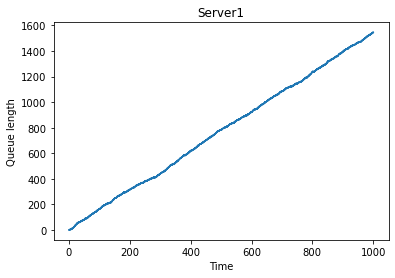

In [14]:
queue_length_time_graph(sybb[0],sybb[7],gtype="queue")

In [7]:
mmn_queueing_jsq(2,10,[3,8],simulation_time=100,simuseed=8)[0]

,Time,Next Customer,Finish Time,Server1,Server1 Available Time,Server1 Queue,Server1 Total,Server2,Server2 Available Time,Server2 Queue,Server2 Total,Live_track,Grand Queue,Grand Total
1,0.000000,0.025710,100.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2,0.025710,0.353506,100.0,1.0,0.097235,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0
3,0.097235,0.353506,100.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0
4,0.353506,0.357982,100.0,1.0,0.448265,0.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0
5,0.357982,1.062516,100.0,1.0,0.448265,0.0,1.0,1.0,0.421984,0.0,1.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,99.843714,99.941292,100.0,1.0,100.252519,9.0,10.0,1.0,100.210544,9.0,10.0,976.0,18.0,20.0
1974,99.941292,99.952886,100.0,1.0,100.252519,10.0,11.0,1.0,100.210544,9.0,10.0,976.0,19.0,21.0
1975,99.952886,99.985615,100.0,1.0,100.252519,10.0,11.0,1.0,100.210544,10.0,11.0,976.0,20.0,22.0
1976,99.985615,100.031209,100.0,1.0,100.252519,11.0,12.0,1.0,100.210544,10.0,11.0,976.0,21.0,23.0
